In [9]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import torch

model = YOLO('runs/detect/train123/weights/best.pt') 

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "default"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [12]:
img_path='ragi.jpg'
img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [13]:
bounding_boxes = []
bbox_start = None
bbox_end = None
drawing = False

def mouse_callback(event, x, y, flags, param):
    global bbox_start, bbox_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        bbox_start = (x, y)
        drawing = True
        # print(f"Start Point: {bbox_start}")
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            bbox_end = (x, y)
            img_copy = img.copy()
            cv2.rectangle(img_copy, bbox_start, bbox_end, (0, 255, 0), 2)
            cv2.imshow("Image", img_copy)

    elif event == cv2.EVENT_LBUTTONUP:
        bbox_end = (x, y)
        drawing = False
        cv2.rectangle(img, bbox_start, bbox_end, (0, 255, 0), 2)
        # print(f"End Point: {bbox_end}")
        # print(f"Bounding Box: {bbox_start}, {bbox_end}")
        bbox_array = np.array([bbox_start[0], bbox_start[1], bbox_end[0], bbox_end[1]])
        bounding_boxes.append(bbox_array)
        cv2.imshow("Image", img)

cv2.imshow("Image", img)
cv2.setMouseCallback("Image", mouse_callback)

while True:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
print(f"Total {len(bounding_boxes)} bounding box(es) captured:")
for i, bbox in enumerate(bounding_boxes):
    print(f"Bounding Box {i + 1}: {bbox}")


Total 1 bounding box(es) captured:
Bounding Box 1: [350 159 542 333]


In [14]:

def calculate_iou_numpy(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between each pair of boxes in box1 and box2 using numpy.

    Parameters:
    - box1: np.ndarray of shape (N, 4) where each row represents [x_min, y_min, x_max, y_max]
    - box2: np.ndarray of shape (M, 4) where each row represents [x_min, y_min, x_max, y_max]

    Returns:
    - IoU matrix of shape (N, M), where the value at (i, j) is the IoU of box1[i] with box2[j]
    """
    # Coordinates of intersection rectangle
    x_min_inter = np.maximum(box1[:, None, 0], box2[:, 0])
    y_min_inter = np.maximum(box1[:, None, 1], box2[:, 1])
    x_max_inter = np.minimum(box1[:, None, 2], box2[:, 2])
    y_max_inter = np.minimum(box1[:, None, 3], box2[:, 3])

    # Calculate intersection area
    inter_width = np.maximum(0, x_max_inter - x_min_inter)
    inter_height = np.maximum(0, y_max_inter - y_min_inter)
    intersection_area = inter_width * inter_height

    # Calculate areas of each box
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    # Calculate IoU
    union_area = box1_area[:, None] + box2_area - intersection_area
    iou = intersection_area / np.maximum(union_area, 1e-10)  # Avoid division by zero
    return iou

def get_indices_of_max_iou_numpy(input_bboxes, candidate_bboxes):
    """
    Get the indices of the bounding boxes with the maximum IoU for each input bounding box.

    Parameters:
    - input_bboxes: np.ndarray of shape (N, 4) for input bounding boxes, each row [x_min, y_min, x_max, y_max].
    - candidate_bboxes: np.ndarray of shape (M, 4), where each row is a bounding box [x_min, y_min, x_max, y_max].

    Returns:
    - Array of indices of candidate bounding boxes with the maximum IoU for each input bounding box, of shape (N,).
    """
    # Calculate IoU matrix
    ious = calculate_iou_numpy(input_bboxes, candidate_bboxes)
    
    # Find the index of the candidate bbox with the maximum IoU for each input bbox
    max_iou_indices = np.argmax(ious, axis=1)
    
    return max_iou_indices


In [15]:
# def calculate_max_overlap(box1, box2):
#     N = box1.shape[0]
#     M = box2.shape[0]

#     max_overlap_indices = np.zeros(N, dtype=int)
#     max_overlap_areas = np.zeros(N)

#     for i in range(N):
#         max_area = 0
#         max_index = -1

#         for j in range(M):
#             x_left = max(box1[i, 0], box2[j, 0])
#             y_top = max(box1[i, 1], box2[j, 1])
#             x_right = min(box1[i, 2], box2[j, 2])
#             y_bottom = min(box1[i, 3], box2[j, 3])

#             if x_right > x_left and y_bottom > y_top:
#                 overlap_width = x_right - x_left
#                 overlap_height = y_bottom - y_top
#                 overlap_area = overlap_width * overlap_height

#                 if overlap_area > max_area:
#                     max_area = overlap_area
#                     max_index = j

#         max_overlap_indices[i] = max_index
#         max_overlap_areas[i] = max_area
    
#     return max_overlap_indices, max_overlap_areas


def label_image_with_max_overlap(input_image, input_bboxes, model=model):
    # Get predictions from the model
    results = model(input_image)
    
    pred_bboxes = []
    pred_classes = []
    
    # Collect predicted bounding boxes and class labels
    for result in results:
        for box in result.boxes:
            pred_bboxes.append([box.xyxy[0].cpu().numpy()[0], box.xyxy[0].cpu().numpy()[1],
                                box.xyxy[0].cpu().numpy()[2], box.xyxy[0].cpu().numpy()[3]])  
            pred_classes.append(int(box.cls[0].cpu().numpy()))

    pred_bboxes = np.array(pred_bboxes)
    
    # Find the indices of bounding boxes with the maximum overlap (IoU)
    max_overlap_indices = get_indices_of_max_iou_numpy(input_bboxes, pred_bboxes)
    
    class_names = model.names 
    labeled_image = input_image.copy()

    for i, bbox in enumerate(input_bboxes):
        # Get the index of the predicted bounding box with the max overlap
        pred_idx = max_overlap_indices[i]
        
        if pred_idx != -1:  # If a valid prediction is found
            class_label = f'{class_names[pred_classes[pred_idx]]}'
            x1, y1, x2, y2 = bbox
            
            # Draw bounding box
            # cv2.rectangle(labeled_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            
            # Calculate the center of the bounding box
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2

            # Calculate the size of the text to center it
            (text_width, text_height), _ = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)

            # Calculate the position to center the text inside the bounding box
            text_x = center_x - text_width // 2
            text_y = center_y + text_height // 2

            # Put the label at the center of the bounding box
            cv2.putText(labeled_image, class_label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    return labeled_image

In [16]:
bboxes = np.array(bounding_boxes)
image = label_image_with_max_overlap(cv2.imread(img_path), bboxes)

cv2.imshow("Labeled Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 480x640 (no detections), 19.9ms
Speed: 3.0ms preprocess, 19.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [9]:
predictor.set_image(image)

In [44]:
input_boxes = torch.tensor(bounding_boxes, device=predictor.device)

In [45]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [46]:
masks.shape

torch.Size([2, 1, 640, 640])

In [47]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

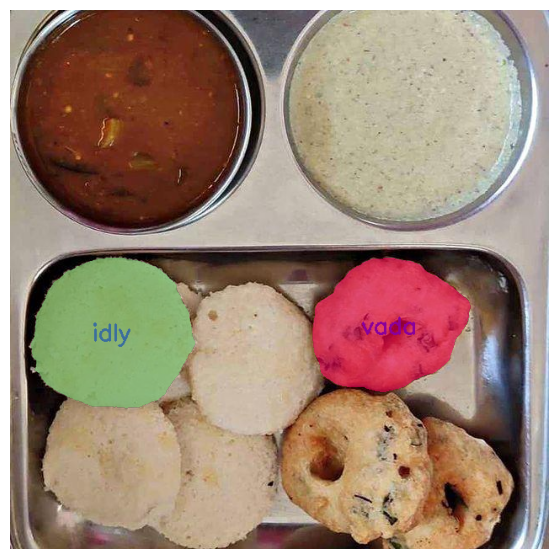

In [48]:
plt.figure(figsize=(10, 7))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()